In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth',-1)

sns.set_style("whitegrid")
sns.set_context('notebook')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (14,6)

In [3]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tools.cli import load_stif,build_nb

In [5]:
df = pd.read_feather('../data/processed/nb-validation-2017.feather')

In [6]:
df.shape

(654978, 5)

In [7]:
df.head()

,kind,date,stop,value,sem
0,autre titre,2017-03-17,barbes-rochechouart,349,s1-2017
1,navigo,2017-03-17,mairie de montreuil,16509,s1-2017
2,imagine r,2017-03-17,mairie de saint-ouen,1807,s1-2017
3,autre titre,2017-03-17,mairie des lilas,172,s1-2017
4,tst,2017-03-17,mairie des lilas,542,s1-2017


## Quick look

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654978 entries, 0 to 654977
Data columns (total 5 columns):
kind     654978 non-null object
date     654978 non-null datetime64[ns]
stop     654978 non-null object
value    654978 non-null int64
sem      654978 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 25.0+ MB


In [9]:
df.describe()

,value
count,654978.000000
mean,1513.947806
std,3614.809873
min,5.000000
25%,121.000000
50%,313.000000
75%,1193.000000
max,115600.000000


In [10]:
df.head()

,kind,date,stop,value,sem
0,autre titre,2017-03-17,barbes-rochechouart,349,s1-2017
1,navigo,2017-03-17,mairie de montreuil,16509,s1-2017
2,imagine r,2017-03-17,mairie de saint-ouen,1807,s1-2017
3,autre titre,2017-03-17,mairie des lilas,172,s1-2017
4,tst,2017-03-17,mairie des lilas,542,s1-2017


In [11]:
df.date.min()

Timestamp('2017-01-01 00:00:00')

In [12]:
df.date.max()

Timestamp('2017-12-31 00:00:00')

## Check assumption

In [13]:
df.date.max()

Timestamp('2017-12-31 00:00:00')

In [14]:
df.date.min()

Timestamp('2017-01-01 00:00:00')

In [15]:
#millions of validated ticket for 2017
df.value.sum()/10**6

991.602506

In [16]:
#nb de stations
assert df.stop.unique().shape[0] == 301

## Monthly traffic

In [17]:
monthly = df.groupby('date').sum().resample('1m').sum()['value']

In [18]:
monthly.index = [elt.month for elt in monthly.index]

Text(0.5,1,'monthly traveler in million')

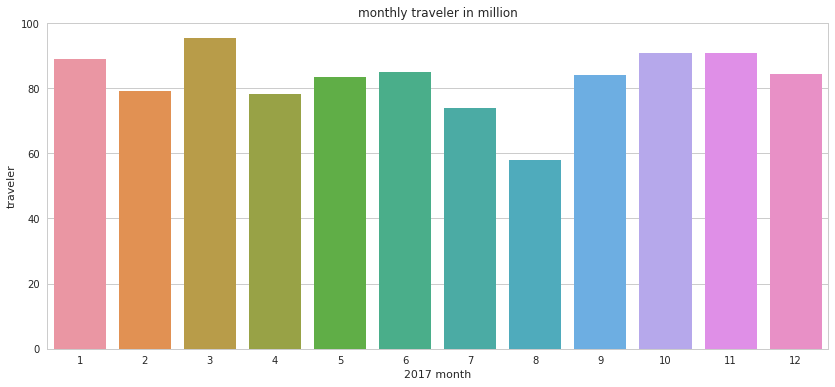

In [19]:
ax= sns.barplot(x=monthly.index,
                y=monthly.div(10**6),
               )
ax.set_xlabel('2017 month')
ax.set_ylabel('traveler')

ax.set_title('monthly traveler in million')


In [20]:
month_pct = monthly.pct_change()

Text(0.5,1,'Change month over month')

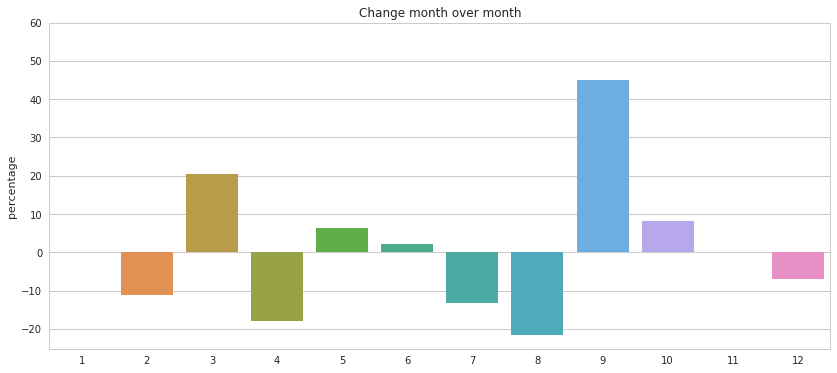

In [21]:
ax= sns.barplot(x=month_pct.index,
                y=month_pct*100,
               )
ax.set_ylim([month_pct.min()-25,60])
ax.set_ylabel('percentage')
ax.set_title('Change month over month')

In [22]:
df.head()

,kind,date,stop,value,sem
0,autre titre,2017-03-17,barbes-rochechouart,349,s1-2017
1,navigo,2017-03-17,mairie de montreuil,16509,s1-2017
2,imagine r,2017-03-17,mairie de saint-ouen,1807,s1-2017
3,autre titre,2017-03-17,mairie des lilas,172,s1-2017
4,tst,2017-03-17,mairie des lilas,542,s1-2017


/home/khalid/.pyenv/versions/3.6.2/envs/paris_metro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


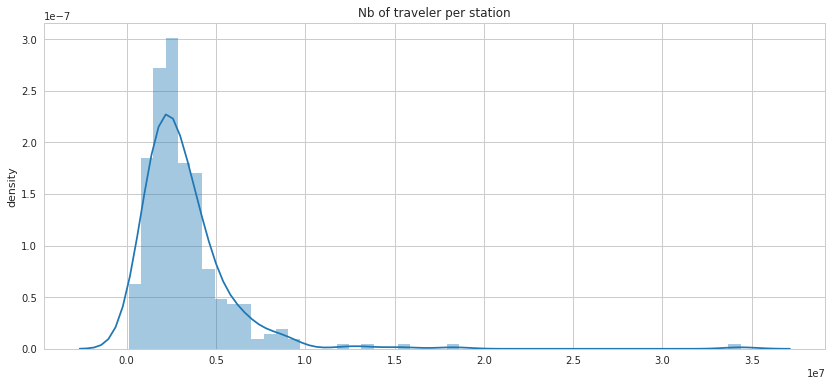

In [23]:
ax = sns.distplot(df.groupby('stop').sum())
ax.set_title('Nb of traveler per station')
x = ax.set_ylabel('density')

## Stop per line

As I'm interested in what is happening on the metro plateform, I'll approximate the number of passenger by dividing the number of line going through a specific station.

Therefore I believe that every line is equally likely to be chosen by a traveler 
which more or less hold according to this [wikipedia draft](https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation)

In [24]:
df_nb_validation = pd.read_feather('../data/processed/nb-validation-2017.feather')


In [25]:
#add_profile(df_nb_validation,df_vac)

In [26]:
from tools.build_features import augment_df_nb,read_vacances,add_profile
import pandas as pd

df_nb_validation = pd.read_feather('../data/processed/nb-validation-2017.feather')
stop_meta = pd.read_feather('../data/processed/meta_stop.feather')
#convert to smooth merging with nb_validation
stop_meta[['stop_lat','stop_lon']] = stop_meta[['stop_lat','stop_lon']].apply(lambda x:x.astype(float))
df_vac = read_vacances('../data/external/fr-en-calendrier-scolaire.csv')
#augment the initial dataset with useful information
dataset = augment_df_nb(df_nb_validation,stop_meta,df_vac)
#FIXME: should be done in upstream
dataset.profile = dataset.profile.str.lower()

In [27]:
#sanity check
nb_kind = 6
bercy_nb_lines = 2
assert dataset.query('stop=="bercy" and date =="2017-01-10" ').shape[0] == nb_kind*bercy_nb_lines

In [28]:
dataset.head()

,kind,date,stop,sem,profile,nbline,traffic_line,is_end,line,stop_lat,stop_lon
0,navigo,2017-03-17,mairie de montreuil,s1-2017,johv,1,16509.0,True,9,48.862283,2.441847
1,autre titre,2017-03-17,mairie de montreuil,s1-2017,johv,1,264.0,True,9,48.862283,2.441847
2,imagine r,2017-03-17,mairie de montreuil,s1-2017,johv,1,3283.0,True,9,48.862283,2.441847
3,tst,2017-03-17,mairie de montreuil,s1-2017,johv,1,1457.0,True,9,48.862283,2.441847
4,amethyste,2017-03-17,mairie de montreuil,s1-2017,johv,1,518.0,True,9,48.862283,2.441847


In [29]:
order = ['1', '2', '3','3B', '4', '5', '6', '7','7B', '8', '9', '10', '11', '12', '13', '14']
mcolor = {'1': 'F5C300',
  '10': 'DCB12B',
  '11': 'B5946C',
  '12': '9DBB9D',
  '13': '99D4DF',
  '14': '9C81B6',
  '2': '98B3DA',
  '3': 'BBBC64',
  '3B': '99D4DF',
  '4': 'D083B2',
  '5': 'F5AC7D',
  '6': 'C4DA99',
  '7': 'F2A5BD',
  '7B': 'C4DA99',
  '8': 'CEADCF',
  '9': 'D6C900'}
colors = ['#'+mcolor[k] for k in order]

Text(0.5,1,'Daily passenger distribution')

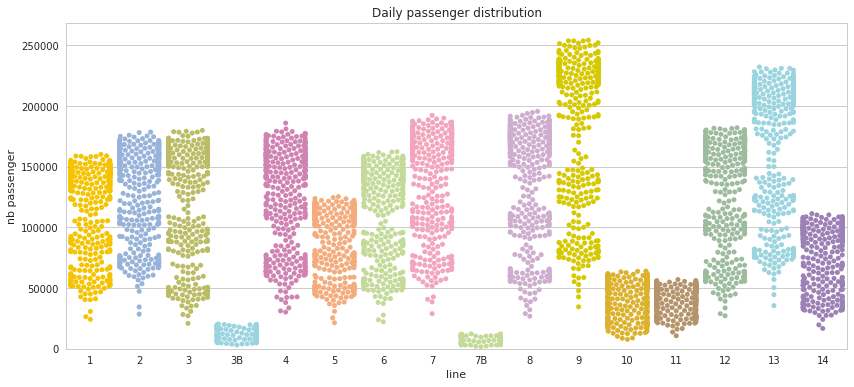

In [30]:
from tools.cli import map_jour_fr
plt.rcParams["figure.figsize"] = (14,6)

palette = sns.color_palette(colors)
line_day = (dataset.groupby(['date','line','profile'])
            .sum()['traffic_line']
            .reset_index()
            .replace({'profile':map_jour_fr})
           .rename(columns={'traffic_line':'nb passenger'}))
ax=sns.swarmplot(data=line_day,
              order=order,
              palette=palette,
            x='line',
            y='nb passenger')
ax.axis(ymin=0)
ax.set_title('Daily passenger distribution')

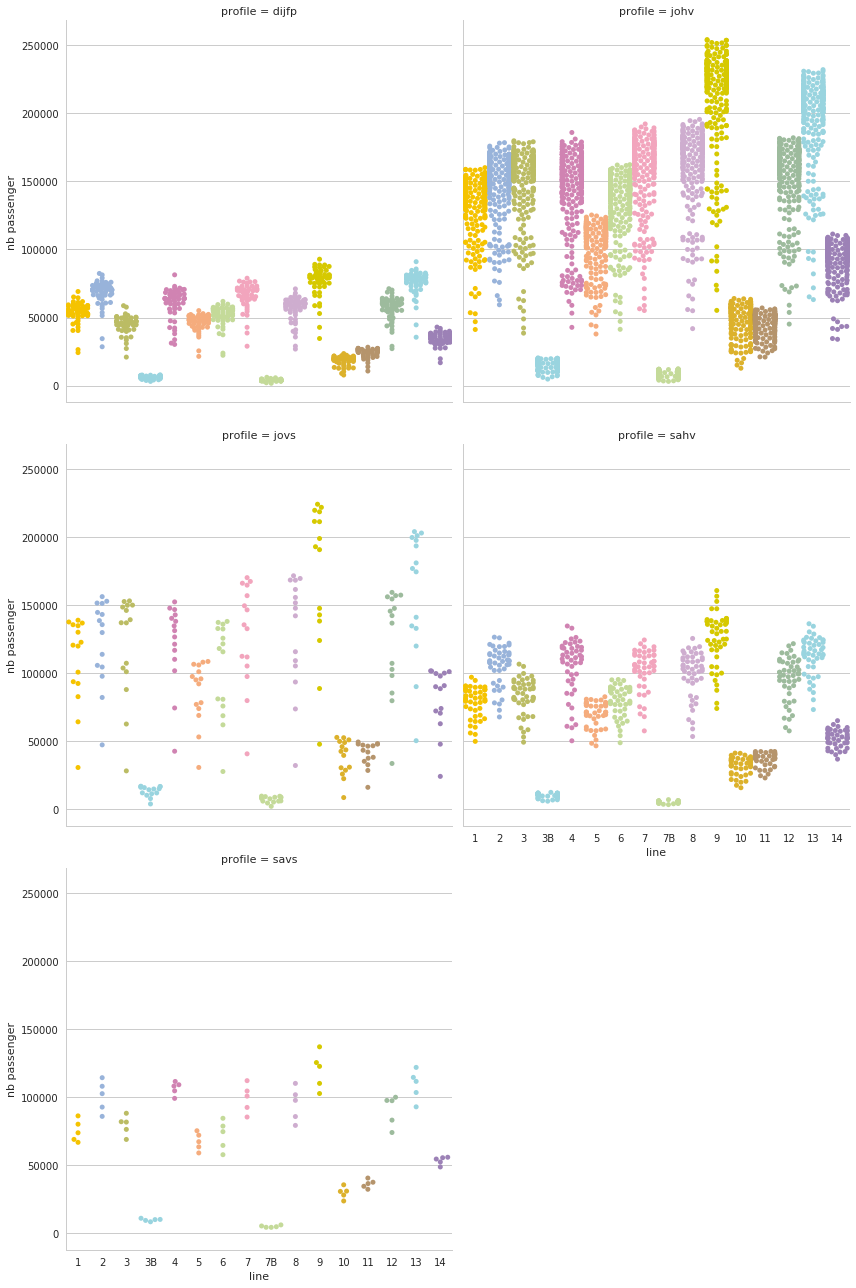

In [31]:
palette = sns.color_palette(colors)

ax=sns.factorplot(
    x='line',
    y='nb passenger',
    col='profile',
    order=order,
    data=line_day,
    palette=palette,
    kind='swarm',
    size=6,
    col_wrap=2
)


In [32]:
dataset.head()

,kind,date,stop,sem,profile,nbline,traffic_line,is_end,line,stop_lat,stop_lon
0,navigo,2017-03-17,mairie de montreuil,s1-2017,johv,1,16509.0,True,9,48.862283,2.441847
1,autre titre,2017-03-17,mairie de montreuil,s1-2017,johv,1,264.0,True,9,48.862283,2.441847
2,imagine r,2017-03-17,mairie de montreuil,s1-2017,johv,1,3283.0,True,9,48.862283,2.441847
3,tst,2017-03-17,mairie de montreuil,s1-2017,johv,1,1457.0,True,9,48.862283,2.441847
4,amethyste,2017-03-17,mairie de montreuil,s1-2017,johv,1,518.0,True,9,48.862283,2.441847


## Estimate traveler per hour

In [33]:
df_profil = pd.read_feather('../data/processed/profile-2017.feather')

In [34]:
df_profil = (df_profil
             .rename(columns={'cat_jour':'profile',
                             'libelle_arret':'stop'}))


In [35]:
group_key = ['kind' ,'date','stop','sem','profile']
daily=(dataset
       .drop_duplicates(group_key)
       .groupby(['date','stop','profile','sem'])
       .agg({'traffic_line':sum})
       .reset_index())

In [36]:
assert daily.query('stop=="bercy" and date =="2017-01-10"').shape[0] == 1

In [37]:
profile = df_profil[['stop','profile','heure','pourc_validations','sem']]

In [38]:
merged = pd.merge(daily,profile,on=['stop','profile','sem']).dropna()
merged['hourly_traffic'] = ((merged.traffic_line * merged.pourc_validations)/100).round(0)

In [39]:
assert merged.query('date == "2017-01-01" and stop =="reuilly-diderot"').shape[0] == 24

In [40]:
#example
merged.query('date == "2017-04-28" and stop =="bercy"').sort_values('heure')

,date,stop,profile,sem,traffic_line,heure,pourc_validations,hourly_traffic
146771,2017-04-28,bercy,johv,s1-2017,5315.5,0.0,1.15,61.0
146774,2017-04-28,bercy,johv,s1-2017,5315.5,1.0,0.22,12.0
146768,2017-04-28,bercy,johv,s1-2017,5315.5,2.0,0.06,3.0
146780,2017-04-28,bercy,johv,s1-2017,5315.5,3.0,0.03,2.0
146776,2017-04-28,bercy,johv,s1-2017,5315.5,4.0,0.02,1.0
146781,2017-04-28,bercy,johv,s1-2017,5315.5,5.0,0.83,44.0
146782,2017-04-28,bercy,johv,s1-2017,5315.5,6.0,1.75,93.0
146769,2017-04-28,bercy,johv,s1-2017,5315.5,7.0,8.05,428.0
146770,2017-04-28,bercy,johv,s1-2017,5315.5,8.0,11.79,627.0
146773,2017-04-28,bercy,johv,s1-2017,5315.5,9.0,5.41,288.0


In [41]:
merged.query('date == "2017-04-28" and stop =="saint-jacques"').sort_values('heure')

,date,stop,profile,sem,traffic_line,heure,pourc_validations,hourly_traffic
623278,2017-04-28,saint-jacques,johv,s1-2017,6342.0,0.0,0.48,30.0
623285,2017-04-28,saint-jacques,johv,s1-2017,6342.0,1.0,0.08,5.0
623286,2017-04-28,saint-jacques,johv,s1-2017,6342.0,2.0,0.00,0.0
623268,2017-04-28,saint-jacques,johv,s1-2017,6342.0,3.0,0.01,1.0
623269,2017-04-28,saint-jacques,johv,s1-2017,6342.0,5.0,0.66,42.0
623270,2017-04-28,saint-jacques,johv,s1-2017,6342.0,6.0,1.72,109.0
623273,2017-04-28,saint-jacques,johv,s1-2017,6342.0,7.0,5.08,322.0
623274,2017-04-28,saint-jacques,johv,s1-2017,6342.0,8.0,12.07,765.0
623287,2017-04-28,saint-jacques,johv,s1-2017,6342.0,9.0,7.60,482.0
623279,2017-04-28,saint-jacques,johv,s1-2017,6342.0,10.0,3.85,244.0
